# Generate paper plots

## download

In [1]:
import datasets
import pandas as pd
from pathlib import Path

/Users/zc478/miniconda3/envs/respect/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
interaction_ds = datasets.load_dataset("lil-lab/respect", name="interaction", split="train")
interaction_ds = interaction_ds.to_pandas()
interaction_ds.head(1)

,game_id,turn,end,s comments,speaker,len,clicks,context,targets,chat,dataset_alias,policy_name,date,round
0,Hc9N5Xmg7NiEK4YrP,10,unsuccessful,It is not understand flat on top,b003f6b44f78d22661a7a31db91004b6,3.218 mins,"[[page4-56.png], [page2-0.png, page4-56.png], ...","[page2-0.png, page2-176.png, page4-56.png, pag...","[page7-102.png, page4-56.png, page1-109.png, p...","[Man with a diamond head, hand facing to the l...",D1,sft,2024-07-18,0


In [3]:
turn_ds = datasets.load_dataset("lil-lab/respect", name="turn", split="train")
turn_ds = turn_ds.to_pandas()
turn_ds.head(1)

,chats,clicks,targets,game_id,end,context,turn_id,currently_selected,deselected,selected,chat_feedback,game_turn_id,prob_action,dataset_alias,policy_name,date,round
0,"[Man with a diamond head, hand facing to the l...",[[page4-56.png]],"[page7-102.png, page4-56.png, page1-109.png, p...",Hc9N5Xmg7NiEK4YrP,0,"[page1-34.png, page1-109.png, page4-113.png, p...",0,[],[],[page4-56.png],Correct. Looks like a big salad bowl with diag...,Hc9N5Xmg7NiEK4YrP_0,0.722408,D1,sft,2024-07-18,0


In [4]:
human_eval_ds = datasets.load_dataset("lil-lab/respect", name="human_eval", split="train")
human_eval_ds = human_eval_ds.to_pandas()
human_eval_ds.head(1)

,correctness,feedback,delta_clicks,game_id,turn_id,round,policy_name,targets,selected,deselected,context,end,currently_selected
0,no,incorrect_satisfaction,[page6-34.png],Bij9bAZbxK2N9ESsi,0,1,bp,"[page7-257.png, page2-129.png, page3-46.png, p...",[page7-203.png],[],"[page2-129.png, page2-26.png, page6-34.png, pa...",0,[]


In [63]:
feedback_binary_ds = datasets.load_dataset("lil-lab/respect", name="feedback_decoder_binary", split="train")
feedback_binary_ds = feedback_binary_ds.to_pandas()
feedback_binary_ds.head(1)

Generating train split: 100%|██████████| 7003/7003 [00:00<00:00, 594336.64 examples/s]


,predictions,labels,game_turn_id,text
0,-1,1,2579svjKSF4AsL3yt_0,User: Please carefully read the following conv...


In [62]:
feedback_ternary_ds = datasets.load_dataset("lil-lab/respect", name="feedback_decoder_ternary", split="train")
feedback_ternary_ds = feedback_ternary_ds.to_pandas()
feedback_ternary_ds.head(1)

Generating train split: 100%|██████████| 7003/7003 [00:00<00:00, 770492.39 examples/s]


,predictions,labels,game_turn_id,text
0,0,1,2579svjKSF4AsL3yt_0,User: Please carefully read the following conv...


## Plots

In [5]:
write_to_output = True
enable_latex = False

output_dir = Path("outputs_no_latex")

errorbar = ("ci", 95)
# n_boot = 10_000
n_boot = 100

alpha = 0.1
pctg_formatter = lambda y: f"{100*y:.0f}\%" if enable_latex else f"{100*y:.0f}%"

### Plotting utils

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

if enable_latex:
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'
    plt.rcParams['mathtext.default'] = 'regular'
else:
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.family'] = 'sans-serif'

plt.rcParams['font.size'] = 24
plt.rcParams['lines.linewidth'] = 2

if write_to_output:
    output_dir.mkdir(exist_ok=True)
    (output_dir/"data").mkdir(exist_ok=True)

In [7]:
from scipy import stats

def compute_bootstrap_ci(data):
    confidence_level = errorbar[1] / 100
    res = stats.bootstrap((data,), np.mean,
                          confidence_level=confidence_level,
                          n_resamples=n_boot, method='percentile', axis=0)
    return res.confidence_interval.low, res.confidence_interval.high

def agg_ci(df, col: str):
    return df\
        .apply(lambda x: pd.Series({
            "count": len(x),
            "mean": x[col].mean(),
            "ci": compute_bootstrap_ci(x[col]), }))\
        .apply(lambda x: pd.Series({
            "count": x["count"],
            "mean": x["mean"],
            "ci_low": x["ci"][0],
            "ci_high": x["ci"][1], }), axis=1)\
        .reset_index()


In [8]:
# latex formatting

def sc_wrap(policy_name):
    if policy_name[1] == "p":
        if enable_latex:
            return f"\\textsc{{{policy_name[0]}-sup}}"
        return f"{policy_name[0]}-sup"
    if policy_name[1] == "a":
        if enable_latex:
            return f"\\textsc{{{policy_name[0]}-rl}}"
        return f"{policy_name[0]}-rl"
    if policy_name[1] == "k":
        if enable_latex:
            return f"\\textsc{{{policy_name[0]}-kto}}"
        return f"{policy_name[0]}-kto"
    if enable_latex:
        return f"\\textsc{{{policy_name}}}"
    return f"{policy_name}"

def force_tick_font(ax, xfmt=id, yfmt=id):
    values = [label.get_position()[0]
                for label in ax.get_xticklabels()]
    # ax.xaxis.set_ticks(values)
    labels = [str(xfmt(value)) for value in values]
    ax.set_xticklabels(labels)

    values = [label.get_position()[1]
                for label in ax.get_yticklabels()]
    # ax.yaxis.set_ticks(values)
    labels = [str(yfmt(value)) for value in values]
    ax.set_yticklabels(labels)

### Main success rate

In [9]:
def plot_main_subplots(ax, ci_results, xkey="cum_sum"):
    sft = ci_results[(ci_results['policy_name'] == 'sft') 
                     & (ci_results['round'] == 0)].copy()

    sft.policy_name = sft.policy_name.apply(
        lambda x: ["bp", "tp", "ba", "ta", "bk", "tk"])
    ci_results = pd.concat([ci_results, sft.explode('policy_name')])
    ci_results = ci_results.sort_values(["round", "policy_name"])

    # plot
    for policy_name in ("bp", "tp", "ba", "ta", "bk", "tk"):
        data = ci_results[ci_results["policy_name"] == policy_name]
        # shift cumsum by 1 row
        data = data.assign(cum_sum=data["count"].shift(1).fillna(0).cumsum())
        ax.plot(data[xkey], data["mean"], label=sc_wrap(policy_name))

        ax.fill_between(data[xkey], data["ci_high"],
                        data["ci_low"], alpha=alpha)

    # add sft
    data = ci_results[ci_results["policy_name"] == "bp"]
    data = data.assign(cum_sum=data["count"].shift(1).fillna(0).cumsum())
    xrange = [data[xkey].min(), data[xkey].max()]
    ci_results_sft = ci_results[ci_results["policy_name"] == "sft"]
    ax.plot(xrange, ci_results_sft["mean"],
            marker="x", color="black", linestyle="--", label=sc_wrap("control"))
    ax.fill_between(xrange, ci_results_sft["ci_high"],
                    ci_results_sft["ci_low"], color="black", alpha=alpha)

    # add human-human
    ci_results_hh = ci_results[ci_results.policy_name == "hh"].iloc[0].to_dict()

    # plot hh as a constant line
    ax.plot(xrange, [ci_results_hh['mean']]*2,
            color="black", label=sc_wrap("hh"), linestyle="dashdot", marker="x")
    ax.fill_between(xrange, [ci_results_hh['ci_low']]*2,
                    [ci_results_hh['ci_high']]*2, color="black", alpha=alpha)

    # asethetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax, ci_results

def click_accuracy(row):
    select_accuracy = [x in row["targets"] for x in row["selected"]]
    deselect_accuracy = [x not in row["targets"] for x in row["deselected"]]
    return select_accuracy + deselect_accuracy

/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y9184

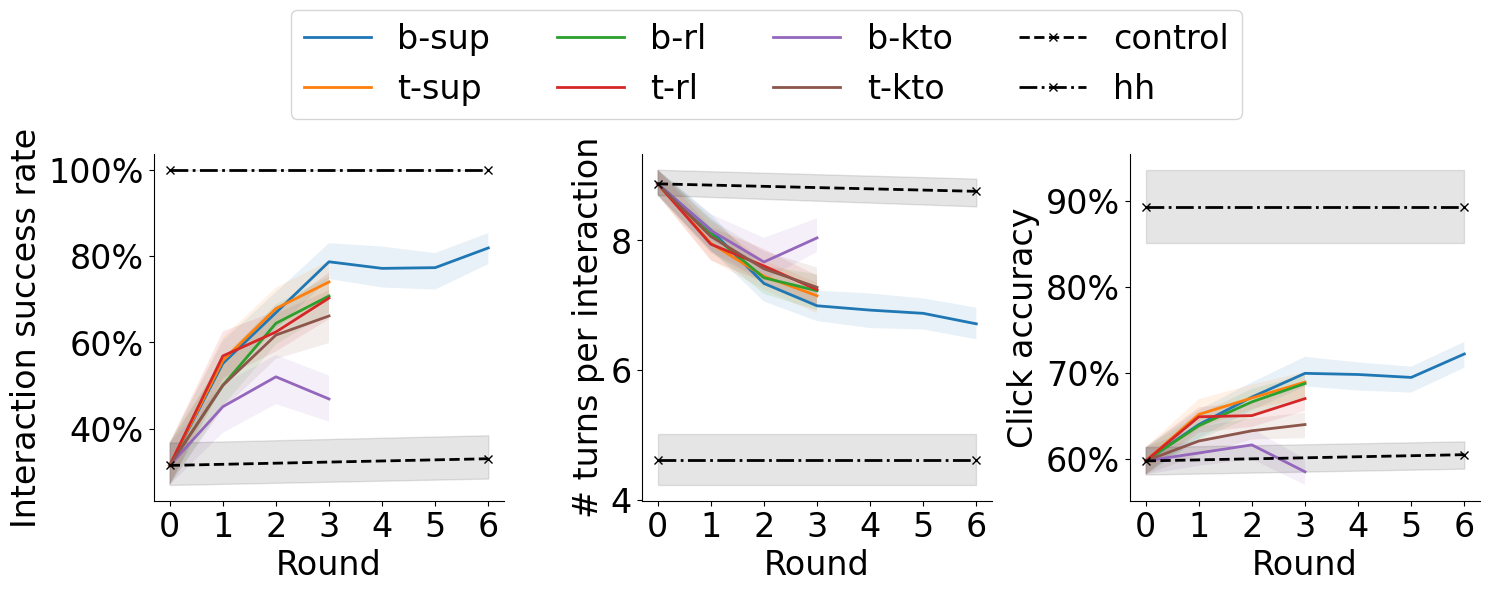

In [10]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)


# interaction success rate
ax = axs[0]
data = turn_ds.groupby(["game_id", "round", "policy_name"]).aggregate(
    {"end": "first"}).reset_index()
ci_results = agg_ci(data.groupby(["policy_name", "round"]), "end")
ax, ci_results = plot_main_subplots(ax, ci_results, xkey="round")
if write_to_output:
    ci_results.to_csv(output_dir/"data/main_interaction_end.csv", index=False)
ax.set_xlabel("Round")
ax.set_ylabel("Interaction success rate")
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


# number of turns per interaction
ax = axs[1]
data = interaction_ds[['game_id', 'round', 'policy_name', 'turn']].copy()
ci_results = agg_ci(data.groupby(["policy_name", "round"]), "turn")
ax, ci_results = plot_main_subplots(ax, ci_results, xkey="round")

if write_to_output:
    ci_results.to_csv(output_dir/"data/main_turn_per_interaction.csv", index=False)
ax.set_xlabel("Round")
if enable_latex:
    ax.set_ylabel("\# turns per interaction")
else:
    ax.set_ylabel("# turns per interaction")
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


ax = axs[2]
data = turn_ds
data = data.assign(click_accuracy=data.apply(
    lambda x: click_accuracy(x), axis=1))
data = data[['game_id', 'turn_id', 'round', 'policy_name', 'click_accuracy']]
data = data.explode('click_accuracy')

ci_results = agg_ci(data.groupby(["policy_name", "round"]), "click_accuracy")
ax, ci_results = plot_main_subplots(ax, ci_results, xkey="round")
if write_to_output:
    ci_results.to_csv(output_dir/"data/main_click_accuracy.csv", index=False)
ax.set_xlabel("Round")
ax.set_ylabel("Click accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# asethetics
plt.tight_layout()
force_tick_font(
    axs[0], xfmt=lambda x: f"{x:.0f}", yfmt=pctg_formatter)
force_tick_font(axs[1], xfmt=lambda x: f"{x:.0f}", yfmt=lambda x: f"{x:.0f}")
force_tick_font(
    axs[2], xfmt=lambda x: f"{x:.0f}", yfmt=pctg_formatter)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           ncols=len(labels) // 2, bbox_to_anchor=(0.5, 1.25))  # (0.5, 1.20) for latex

In [11]:
if write_to_output:
    fig.savefig(output_dir/"main.pdf", bbox_inches='tight')

### Cum_sum v. round

/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


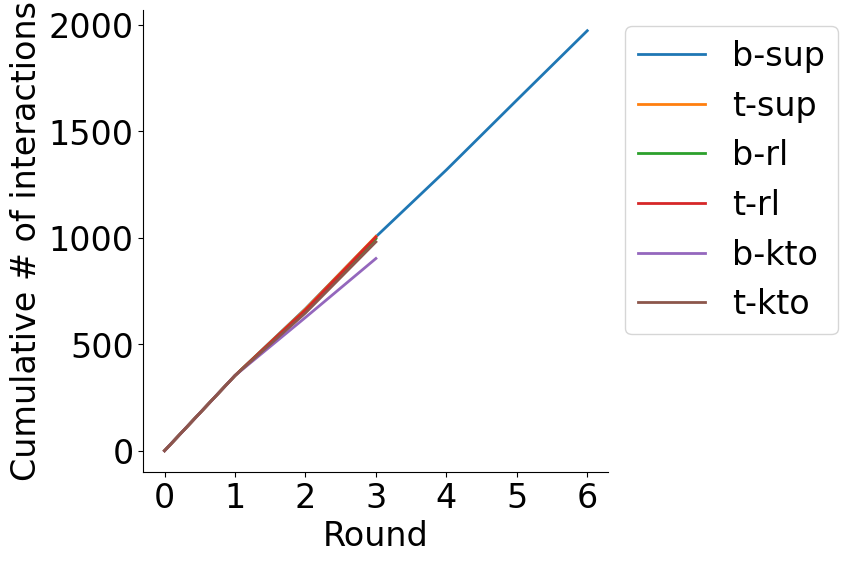

In [12]:
data = turn_ds.groupby(["game_id", "round", "policy_name"]).aggregate(
    {"end": "first"}).reset_index()
data = data.groupby(["policy_name", "round"]).aggregate(
    {"end": ["count"]}).reset_index().droplevel(1, axis=1)

out = []
for policy_name in ["bp", "tp", "ba", "ta", "bk", "tk"]:
    d = data[(data["policy_name"] == policy_name) | ((data["policy_name"] == "sft") & (data["round"] == 0))]
    d = d.sort_values("round")
    d = d.assign(cum_sum=d["end"].shift(1).fillna(0).cumsum().astype(int))
    length = len(d)
    for i in range(length):
        out.append([policy_name, d['round'].iloc[i],
            d['cum_sum'].iloc[i], d['end'].iloc[i]])
out = pd.DataFrame(out, columns=["policy_name", "round", "cum_sum", "count"])

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
for policy_name in ["bp", "tp", "ba", "ta", "bk", "tk"]:
    data1 = out[out["policy_name"] == policy_name]
    sns.lineplot(x="round", y="cum_sum", data=data1, label=sc_wrap(policy_name))
ax.set_xlabel("Round")
if enable_latex:
    ax.set_ylabel("Cumulative \# of interactions")
else:
    ax.set_ylabel("Cumulative # of interactions")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# turn off spine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
force_tick_font(ax, xfmt=lambda x: f"{x:.0f}", yfmt=lambda y: f"{y:.0f}")

In [13]:
if write_to_output:
    fig.savefig(output_dir/"interaction_cumsum.pdf", bbox_inches='tight')
    out.to_csv(output_dir/"data/interaction_cumsum.csv", index=False)

### Language analysis

In [14]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize


def ling_stats(df):
    corpus = "\n".join(df.chat.apply(lambda x: "\n".join(x)))
    tokens = word_tokenize(corpus.lower())
    tokens = [word for word in tokens if word.isalnum()]
    vocab_size = len(set(tokens))
    num_utterances = df.turn.sum()

    # Calculate unigram frequency distribution
    fdist = FreqDist(tokens)
    return dict(
        vocab_size=vocab_size,
        fdist=fdist,
        avg_num_tokens=len(tokens) / num_utterances,
        num_utterances=num_utterances,
        avg_num_turns=df.turn.mean()
    )

In [15]:
ling_ds = interaction_ds
ling_ds = ling_ds.assign(
    avg_chat_len = ling_ds.chat.apply(lambda x: sum([len(u.split(" ")) for u in x]) / len(x))
)

In [16]:
lstats = ling_ds.groupby(['policy_name', 'round']).apply(ling_stats).apply(pd.Series).reset_index()
lstats.head(1)

,policy_name,round,vocab_size,fdist,avg_num_tokens,num_utterances,avg_num_turns
0,ba,1,1352,"{'a': 1254, 'whistle': 1, 'no': 454, 'those': ...",8.291246,2479,8.101307


In [17]:
import re
from collections import Counter

frustrated_words = ["reset",
                    "restart",
                    "from scratch",
                    "all over",
                    "start over",
                    "deselect everything", "deselect all",
                    "remove everything", "remove all",
                    "clear everything", "clear all",
                    "unselect everything", "unselect all",
                    "drop everything", "drop all"]


lazy_words = [
    "try again",
    "try one more time",
    "the other one",
]


def count_special_words(corpus, word_list):
    ws = [re.escape(word) for word in word_list]
    ws = "|".join(ws)
    ws = re.compile(ws)
    out = ws.findall(corpus.lower())
    return len(out), Counter(out)


def ling_corpus(df):
    return {"corpus": "\n".join(df.chat.apply(lambda x: "\n".join(x)))}

lcorpus = ling_ds.groupby(['policy_name', 'round']).apply(
    ling_corpus).reset_index()
lcorpus.rename(columns={0: "corpus"}, inplace=True)


lcorpus = lcorpus.assign(
    frustrated=lcorpus.corpus.apply(
        lambda x: count_special_words(x['corpus'], frustrated_words)),
    lazy=lcorpus.corpus.apply(
        lambda x: count_special_words(x['corpus'], lazy_words)),
)
lcorpus = lcorpus.assign(
    num_frustrated=lcorpus.frustrated.apply(lambda x: x[0]),
    num_lazy=lcorpus.lazy.apply(lambda x: x[0]),
)

/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y9184

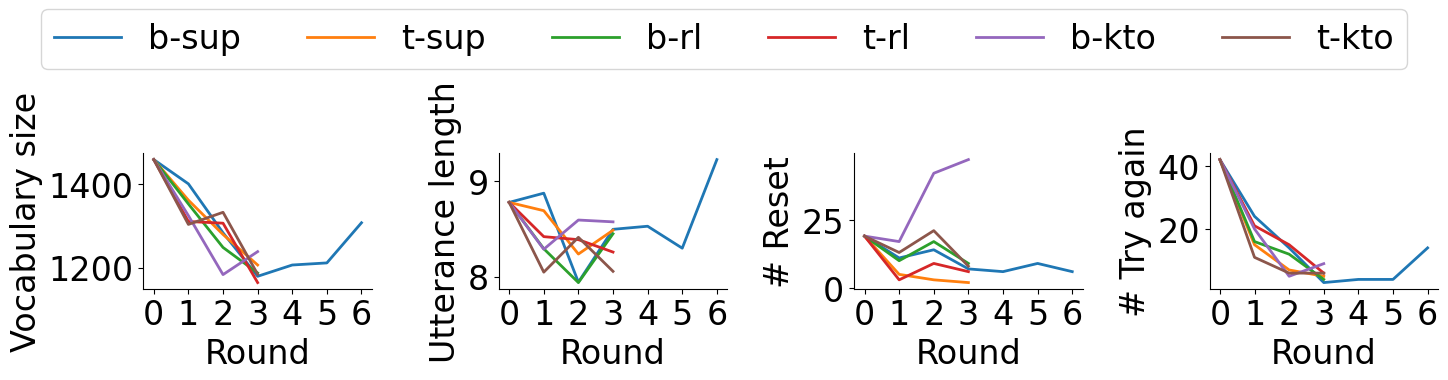

In [18]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(15, 2.5)


policy_names = ['bp', 'tp', 'ba', 'ta', 'bk', 'tk']
# vocab size
ax = axs[0]
for policy_name in policy_names:
    data = lstats[(lstats.policy_name == policy_name) | ((lstats.policy_name == "sft") & (lstats['round'] == 0))]
    data = data.sort_values("round")
    color = "black" if policy_name == "sft" else None
    ax.plot(data['round'], data['vocab_size'], label=sc_wrap(policy_name), color=color)
ax.set_ylabel("Vocabulary size")

# avg num tokens
ax = axs[1]
for policy_name in policy_names:
    data = lstats[(lstats.policy_name == policy_name) | ((lstats.policy_name == "sft") & (lstats['round'] == 0))]
    data = data.sort_values("round")
    color = "black" if policy_name == "sft" else None
    ax.plot(data['round'], data['avg_num_tokens'], label=sc_wrap(policy_name), color=color)
ax.set_ylabel("Utterance length")

# frustration
ax = axs[2]
for policy_name in policy_names:
    data = lcorpus[(lcorpus.policy_name == policy_name) | ((lcorpus.policy_name == "sft") & (lcorpus['round'] == 0))]
    data = data.sort_values("round")
    color = "black" if policy_name == "sft" else None
    ax.plot(data['round'], data['num_frustrated'], label=sc_wrap(policy_name), color=color)
if enable_latex:
    ax.set_ylabel("\# Reset")
else:
    ax.set_ylabel("# Reset")

# laziness
ax = axs[3]
for policy_name in policy_names:
    data = lcorpus[(lcorpus.policy_name == policy_name) | ((lcorpus.policy_name == "sft") & (lcorpus['round'] == 0))]
    data = data.sort_values("round")
    color = "black" if policy_name == "sft" else None
    ax.plot(data['round'], data['num_lazy'], label=sc_wrap(policy_name), color=color)
if enable_latex:
    ax.set_ylabel("\# Try again")
else:
    ax.set_ylabel("# Try again")

# asethetics
plt.tight_layout()
for a in axs:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.legend().remove()
    a.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    a.set_xlabel("Round")
    force_tick_font(a, xfmt=lambda x: f"{x:.0f}", yfmt=lambda y: f"{y:.0f}")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           ncols=len(labels), bbox_to_anchor=(0.5, 1.5))  # (0.5, 1.35) for latex

In [19]:
if write_to_output:
    fig.savefig(output_dir/"ling.pdf", bbox_inches='tight')

### Chat len across workers

Text(0.5, 1.0, 'avg chat len for all speakers')

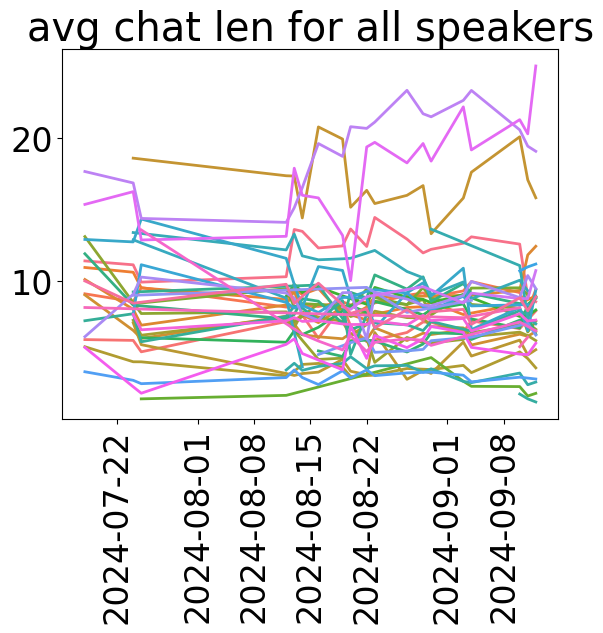

In [20]:
data = ling_ds.copy()
data = data.groupby(['speaker', 'date']).aggregate(
    {'avg_chat_len': 'mean'}).reset_index()
sns.lineplot(x='date', y='avg_chat_len', hue='speaker', data=data)
plt.legend().remove()
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90)
plt.title("avg chat len for all speakers")

### Human eval for bp

In [21]:
human_eval_ds.head(1)

,correctness,feedback,delta_clicks,game_id,turn_id,round,policy_name,targets,selected,deselected,context,end,currently_selected
0,no,incorrect_satisfaction,[page6-34.png],Bij9bAZbxK2N9ESsi,0,1,bp,"[page7-257.png, page2-129.png, page3-46.png, p...",[page7-203.png],[],"[page2-129.png, page2-26.png, page6-34.png, pa...",0,[]


In [22]:
# load look up tables
import pickle

clip_sim_path = "../data/clip_model1_similarities.pkl"

with open(clip_sim_path, mode="rb") as f:
    clip_sim = pickle.load(f)

clip_sim_df = pd.DataFrame(clip_sim)
clip_sim_df.head(1)

,page5-178,page5-144,page5-150,page3-129,page1-37,page8-198,page7-257,page5-187,page6-16,page5-193,...,page8-22,page3-124,page8-181,page6-27,page8-195,page3-130,page1-0,page8-142,page5-175,page8-156
page5-144,-0.072367,NaN,0.216064,0.039342,0.08056,0.034206,0.098113,0.483865,0.077306,0.185756,...,0.0379,-0.013866,0.056063,0.126494,-0.037855,-0.000195,0.043222,-0.05586,0.33889,0.003096


In [23]:
import itertools

def action_sem_dist(row, sim_lookup=clip_sim_df):
    h_clicks = set(row['delta_clicks'])
    pre_click_selected = set(row['currently_selected'])
    h_delected = pre_click_selected & h_clicks
    h_selected = h_clicks - h_delected
    b_selected = set(row['selected'])
    b_deselected = set(row['deselected'])
    selected_pairs = list(itertools.product(h_selected, b_selected))
    deselected_pairs = list(itertools.product(h_delected, b_deselected))
    
    def lookup(p1, p2):
        return sim_lookup[p1.removesuffix('.png')][p2.removesuffix('.png')]
    
    selected_sim = pd.Series(
        [lookup(p1, p2) for p1, p2 in selected_pairs]).fillna(1.0)
    deselect_sim = pd.Series(
        [lookup(p1, p2) for p1, p2 in deselected_pairs]).fillna(1.0)
        
    if len(selected_sim) == 0:
        selected_sim = pd.Series([-1.0] * max(len(h_selected), len(b_selected)))
    if len(deselect_sim) == 0:
        deselect_sim = pd.Series([-1.0] * max(len(h_delected), len(b_deselected)))

    return {
        "selected_sim": selected_sim.mean(),
        "deselected_sim": deselect_sim.mean(),
        "clicks_sim": pd.concat([selected_sim, selected_sim]).mean()
    }

action_sem_dist(human_eval_ds.iloc[1], clip_sim_df)

{'selected_sim': 0.0240088552236557,
 'deselected_sim': nan,
 'clicks_sim': 0.0240088552236557}

In [24]:
human_eval_sim_ds = human_eval_ds.join(human_eval_ds.apply(action_sem_dist, axis=1).apply(pd.Series))

/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y9184

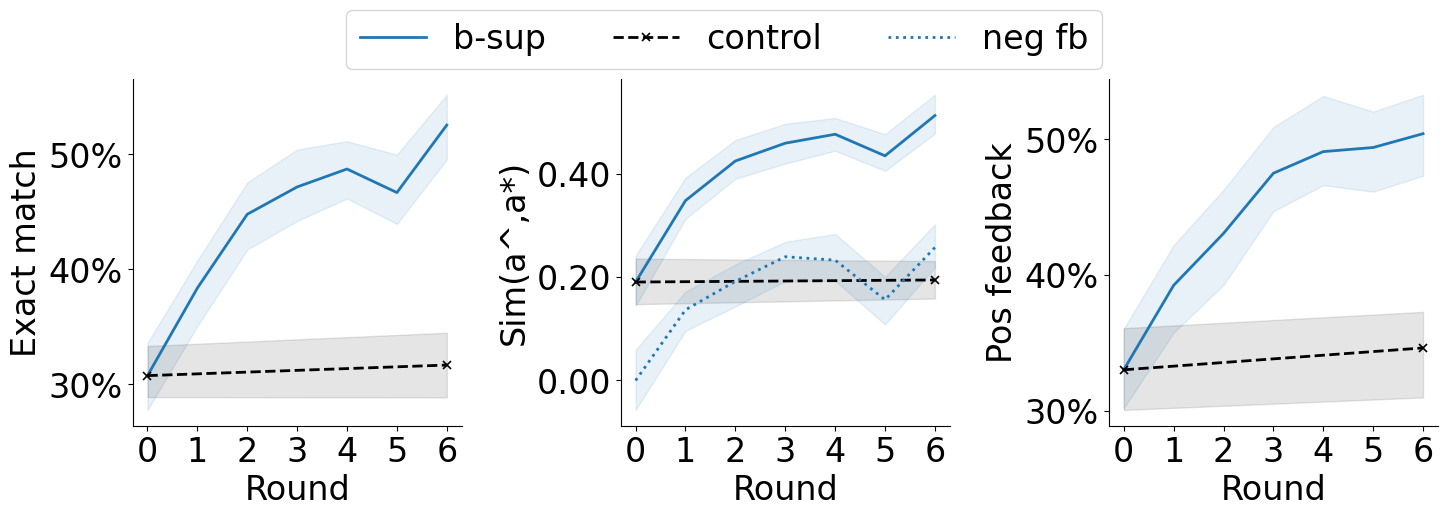

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

err_kws = {"alpha": .1}

sft_kws = {
    "color": "black",
    "marker": "x", 
    "linestyle": "--", 
    "markerfacecolor":'black', 
    "markeredgecolor":'black',
    'markeredgewidth': 1.2,
    }

data = human_eval_ds

data = data.assign(feedback=data['feedback'].map(
    {'yes': 1, 'no': 0, 'incorrect_satisfaction': 0, 'partial_correctness_satisfaction': 0}))
data = data.assign(correctness=data['correctness'].map({'yes': 1, 'no': 0}))
data_bp = data[(data.policy_name == 'bp') | (
    (data.policy_name == 'sft') & (data['round'] == 0))]
data_sft = data[(data.policy_name == 'sft')]

ax = axs[0]
sns.lineplot(data=data_bp, x='round', y='correctness', 
             ax=ax, label=sc_wrap("bp"), err_kws=err_kws, n_boot=n_boot)
sns.lineplot(data=data_sft, x='round', y='correctness', 
             ax=ax, label=sc_wrap("control"),
             err_kws=err_kws, n_boot=n_boot, **sft_kws)
ax.set_xlabel('Round')
ax.set_ylabel(r'Exact match')

ax = axs[2]
sns.lineplot(data=data_bp, x='round', y='feedback', ax=ax, label=sc_wrap("bp"),
             err_kws=err_kws, n_boot=n_boot)
sns.lineplot(data=data_sft, x='round', y='feedback', ax=ax, label=sc_wrap(
    "control"), err_kws=err_kws, n_boot=n_boot, **sft_kws)

ax.set_xlabel('Round')
ax.set_ylabel('Pos feedback')


color = sns.color_palette("tab10")[0]

ax = axs[1]
data = human_eval_sim_ds
data_bp = data[(data.policy_name == 'bp') | (
    (data.policy_name == 'sft') & (data['round'] == 0))]
data_sft = data[(data.policy_name == 'sft')]
sns.lineplot(data=data_bp, x='round', y='clicks_sim', ax=ax, label=sc_wrap("bp"),
             err_kws=err_kws, n_boot=n_boot)
sns.lineplot(data=data_sft, x='round', y='clicks_sim', ax=ax, label=sc_wrap("control"), err_kws=err_kws, n_boot=n_boot, **sft_kws)
sns.lineplot(data=data_bp[data_bp.feedback != "yes"], x='round', y='clicks_sim',
             ax=ax, err_kws=err_kws, n_boot=n_boot, color=color, linestyle=':', label="\\textsc{neg fb}" if enable_latex else "neg fb")

if enable_latex:
    ax.set_ylabel(r'Sim($\hat a,a^*$)')
else:
    ax.set_ylabel("Sim(a^,a*)")

ax.set_xlabel('Round')

for i, ax in enumerate(axs):
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    if i == 1:
        force_tick_font(ax, xfmt=int, yfmt=lambda x: f'{x:.2f}')
    else:
        force_tick_font(ax, xfmt=int, yfmt=pctg_formatter)

# legend
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

fig.tight_layout()

In [72]:
if write_to_output:
    fig.savefig(output_dir/"human_eval.pdf", bbox_inches='tight')

In [27]:
data = human_eval_ds
data = data.assign(feedback=data['feedback'].map(
    {'yes': 1, 'no': 0, 'incorrect_satisfaction': 0, 'partial_correctness_satisfaction': 0}))
data = data.assign(correctness=data['correctness'].map({'yes': 1, 'no': 0}))
data_agg = data.groupby(['round', 'policy_name']).aggregate(
    {'correctness': 'mean', 'feedback': 'mean'})
data_agg = data_agg.reset_index()
if write_to_output:
    data_agg.to_csv(output_dir/"data/human_eval.csv", index=False)
data_agg

,round,policy_name,correctness,feedback
0,0,sft,0.307460,0.330306
1,1,bp,0.383616,0.392491
2,2,bp,0.447791,0.430733
3,3,bp,0.471545,0.475059
4,4,bp,0.487153,0.490975
5,5,bp,0.466667,0.493990
6,6,bp,0.525355,0.504172
7,6,hh,0.791111,0.784091
8,6,sft,0.316650,0.346420


### LoRa enhanced

In [28]:
data = turn_ds[turn_ds.policy_name.isin(['sft', 'bp', 'bp+'])].groupby(["dataset_alias", "policy_name", "round", "game_id"]).aggregate({"end": "first"}).reset_index()

ci_results = ci_results = data.groupby(["dataset_alias", "policy_name", "round"])\
    .apply(lambda x: pd.Series({
        "end_count": len(x),
        "end_mean": x["end"].mean(),
        "end_ci": compute_bootstrap_ci(x["end"]),}))\
    .apply(lambda x: pd.Series({
        "count": x["end_count"],
        "mean": x["end_mean"],
        "ci_low": x["end_ci"][0],
        "ci_high": x["end_ci"][1],}), axis=1)\
    .reset_index()

ci_results_main = ci_results[ci_results.dataset_alias.isin(
    ["D1", "D2", "D3", "D4", "D5", "D6", "D7"])]
ci_results_main = ci_results_main.sort_values(["round"])
ci_results_main = ci_results_main.assign(cum_sum=ci_results_main["count"].shift(1).fillna(0).cumsum())
ci_results_main

,dataset_alias,policy_name,round,count,mean,ci_low,ci_high,cum_sum
0,D1,sft,0,353.0,0.314448,0.261969,0.365439,0.0
2,D2,bp,1,314.0,0.550955,0.493631,0.597213,353.0
3,D3,bp,2,338.0,0.668639,0.621154,0.717678,667.0
4,D4,bp,3,314.0,0.786624,0.751592,0.829697,1005.0
5,D5,bp,4,328.0,0.771341,0.739253,0.817073,1319.0
7,D6,bp,5,326.0,0.773006,0.726840,0.811426,1647.0
9,D7,bp,6,320.0,0.818750,0.779609,0.861016,1973.0


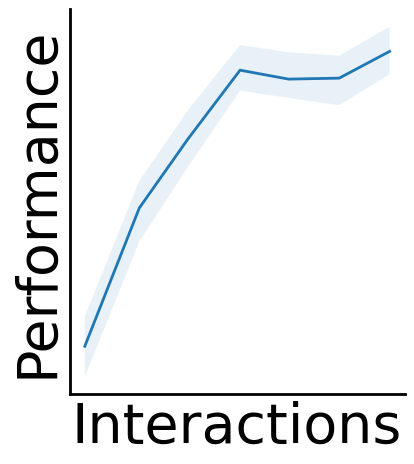

In [29]:
# line plot with matplotlib
plt.figure(figsize=(5, 5))
color = sns.color_palette("tab10")[0]
ax = plt.plot(ci_results_main["cum_sum"], ci_results_main["mean"], color=color)
plt.fill_between(ci_results_main["cum_sum"],
                 ci_results_main["ci_high"],
                ci_results_main["ci_low"],
                 alpha=0.1)
# plt.plot(ci_results_main["cum_sum"], [0.2] * len(ci_results_main), color="black")
plt.tight_layout()
plt.xticks([])
plt.yticks([])
# for spine in plt.gca().spines.values():
    # spine.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.xlabel("Interactions", fontsize=40)
plt.ylabel("Performance", fontsize=40)
# set spine thickness
if write_to_output:
    plt.savefig(output_dir/"performance.pdf", bbox_inches='tight')
    ci_results_main.to_csv(output_dir/"data/performance.csv", index=False)
plt.show()

In [30]:
ci_results_enchanced = ci_results[ci_results.dataset_alias.isin(["D5'", "D6'", "D4"])]
ci_results_enchanced

,dataset_alias,policy_name,round,count,mean,ci_low,ci_high
4,D4,bp,3,314.0,0.786624,0.751592,0.829697
6,D5',bp+,4,330.0,0.812121,0.774167,0.854697
8,D6',bp+,5,311.0,0.826367,0.781350,0.869855


/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/var/folders/1v/qzyy3mlx2c5dn1b1n98y91840000gp/T/ipykernel_69152/4147988013.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


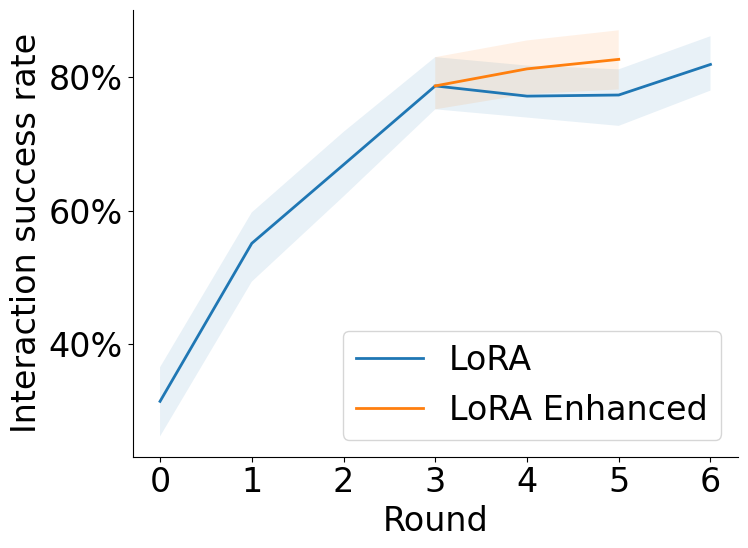

In [31]:
# line plot with matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
color = sns.color_palette("tab10")[0]
plt.plot(ci_results_main["round"], ci_results_main["mean"], color=color)
plt.plot(ci_results_enchanced["round"], ci_results_enchanced["mean"], color=sns.color_palette("tab10")[1])
plt.fill_between(ci_results_main["round"],
                 ci_results_main["ci_high"],
                 ci_results_main["ci_low"],
                 alpha=0.1)
plt.fill_between(ci_results_enchanced["round"],
                 ci_results_enchanced["ci_high"],
                 ci_results_enchanced["ci_low"],
                 alpha=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(["LoRA", "LoRA Enhanced"])
ax.set_xlabel("Round")
ax.set_ylabel("Interaction success rate")
# set int ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
force_tick_font(ax, xfmt=int, yfmt=pctg_formatter)
plt.tight_layout()
plt.show()

In [32]:
if write_to_output:
    ci_results_enchanced.to_csv(output_dir/"data/enhanced.csv", index=False)
    fig.savefig(output_dir/"enhanced.pdf", bbox_inches='tight')

### feedback decoder

In [42]:
human_eval_ds.columns

Index(['correctness', 'feedback', 'delta_clicks', 'game_id', 'turn_id',
       'round', 'policy_name', 'targets', 'selected', 'deselected', 'context',
       'end', 'currently_selected'],
      dtype='object')

In [38]:
turn_ds.columns

Index(['chats', 'clicks', 'targets', 'game_id', 'end', 'context', 'turn_id',
       'currently_selected', 'deselected', 'selected', 'chat_feedback',
       'game_turn_id', 'prob_action', 'dataset_alias', 'policy_name', 'date',
       'round'],
      dtype='object')

In [64]:
def read_rd_main(rd_df: pd.DataFrame) -> pd.DataFrame:
    rd_df = rd_df.assign(
        game_id = rd_df['game_turn_id'].apply(lambda x: x.split("_")[0]),
        turn_id = rd_df['game_turn_id'].apply(lambda x: int(x.split("_")[1])),
    )
    rd_df = rd_df.rename(columns={'predictions': 'rd_prediction', 'labels': 'rd_label'})
    rddf = pd.merge(rd_df[['rd_prediction', 'game_id', 'turn_id',
                    'rd_label']], human_eval_ds, how='left', on=['game_id', 'turn_id'])
    rddf2 = rddf[['rd_prediction', 'feedback', 'game_id', 'turn_id',
                'round', 'policy_name',]]
    feedback_to_numerical = {
        "yes": 1,
        "no": -1,
        "incorrect_satisfaction": 0,
        "partial_correctness_satisfaction": 0,
    }
    rddf2 = rddf2.assign(rd_feedback=rddf2.feedback.map(feedback_to_numerical))
    rddf2 = rddf2.assign(
        rd_accuracy=(rddf2.rd_prediction == rddf2.rd_feedback).astype(int))
    return rddf2

In [73]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, ax, plot_labels=False):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum()
    sns.heatmap(cm, cmap="Blues", ax=ax, vmin=0., vmax=0.6, 
                # annot=True, fmt=".2f", 
                square=True, cbar=False)
    # # label each cell with the numeric value
    for (i, j) in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if not i == j:
            continue
        val = cm[i, j]
        color = 'black' if val < 0.30 else 'white'
        if cm[i, j] == 0:
            text = "-"
        else:
            text = f"{cm[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=color)
    if plot_labels:
        ax.set_ylabel("Act")
        ax.set_yticklabels(["neg", "neu", "pos"])
        ax.set_xticklabels(["neg", "neu", "pos"])
        ax.set_xlabel("Pred")
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
    else:
        ax.set_xticks([])
        ax.set_yticks([])

def plot_group_confusion_matrix(data):
    fig, axs = plt.subplots(1, 7, figsize=(20, 4))
    for i, (round_name, group) in enumerate(data.groupby('round')):
        y_true = group['rd_feedback']
        y_pred = group['rd_prediction']
        plot_confusion_matrix(y_true, y_pred, axs[i], plot_labels=(i == 0))
    return fig

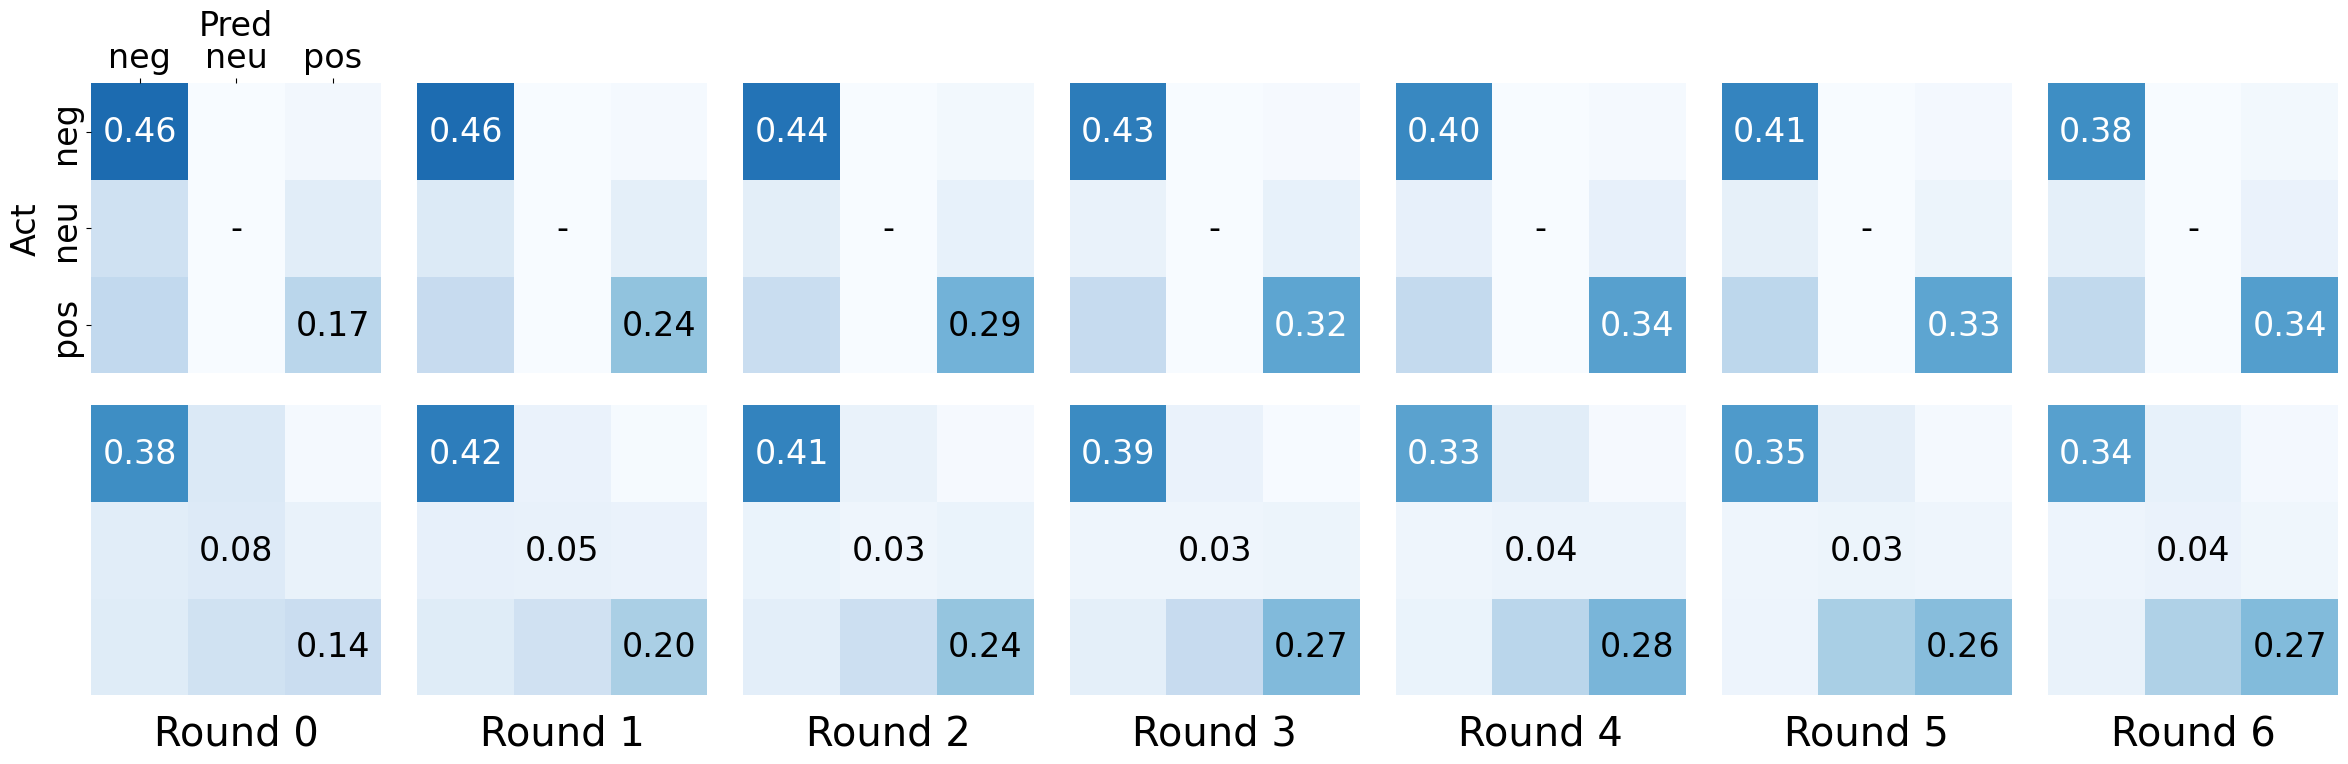

In [74]:
# combine matrices

fig, axs = plt.subplots(2, 7, figsize=(24, 8))

# binary
rddf = read_rd_main(feedback_binary_ds)
data = rddf[(rddf.policy_name == 'bp') | (
    (rddf.policy_name == 'sft') & (rddf['round'] == 0))]
for i, (round_name, group) in enumerate(data.groupby('round')):
    y_true = group['rd_feedback']
    y_pred = group['rd_prediction']
    plot_confusion_matrix(y_true, y_pred, axs[0, i], plot_labels=(i == 0))

# ternary
rddf = read_rd_main(feedback_ternary_ds)
data = rddf[(rddf.policy_name == 'bp') | (
    (rddf.policy_name == 'sft') & (rddf['round'] == 0))]
for i, (round_name, group) in enumerate(data.groupby('round')):
    ax = axs[1, i]
    y_true = group['rd_feedback']
    y_pred = group['rd_prediction']
    plot_confusion_matrix(y_true, y_pred, ax)
    if enable_latex:
        ax.set_title(f"$\\rho=\\textnormal{round_name}$", y=-0.2)
    else:
        ax.set_title(f"Round {round_name}", y=-0.2)


fig.tight_layout()

In [75]:
if write_to_output:
    fig.savefig(output_dir/"rd_confusion.pdf", bbox_inches='tight')